In [ ]:
'''
This routine detects heatwave events across the entire spatial grid using the 95th percentile threshold, generating a dataset with event flags, magnitudes, and anomalies.

Daniela Risaro
July 2025
'''


In [1]:
import xarray as xr
import numpy as np 
import pandas as pd
import os 


In [2]:
def detect_events(arr_bool):
    result = np.zeros_like(arr_bool, dtype=np.int8)
    count = 0
    for i in range(len(arr_bool)):
        if arr_bool[i]:
            count += 1
        else:
            if count >= 3:
                result[i - count:i] = 1
            count = 0
    if count >= 3:
        result[len(arr_bool) - count:] = 1
    return result

In [3]:

data_processed_dir = "../data/processed/"
data_raw_dir = "../data/raw/"

file_percentiles = 'tmax2m_percentiles_1995_2024.nc'
files_raw = sorted([file for file in os.listdir(data_raw_dir) if file.endswith(".nc")])

ds_percentiles = xr.open_dataset(data_processed_dir + file_percentiles)

percentile = 95 
p_percentile = ds_percentiles[f't2m_p{percentile}']


In [4]:

list_datasets = []

list_years = np.arange(2015, 2026)

for year in list_years:
    print(f"Processing year {year}")
    ds_year = xr.open_dataset(data_raw_dir + [f for f in files_raw if str(year) in f][0])
    ds_year = ds_year["t2m"] - 273.15
    ds_year['doy'] = ds_year["valid_time"].dt.dayofyear

    time_len = ds_year.sizes["valid_time"]
    lat_len = len(ds_percentiles.latitude)
    lon_len = len(ds_percentiles.longitude)

    dummy_all = np.zeros((time_len, lat_len, lon_len), dtype=np.int8)
    magnitude_all = np.full((time_len, lat_len, lon_len), np.nan, dtype=np.float32)
    anomaly_all = np.full((time_len, lat_len, lon_len), np.nan, dtype=np.float32)

    for lat_idx in range(lat_len):
        for lon_idx in range(lon_len):
            target_year_point = ds_year.isel(latitude=lat_idx, longitude=lon_idx)
            p_percentile_point = p_percentile.isel(latitude=lat_idx, longitude=lon_idx)
            threshold = p_percentile_point.sel(doy=target_year_point['doy'])

            excess = target_year_point - threshold
            exceeds = excess > 0

            dummy = detect_events(exceeds.values)
            dummy_all[:, lat_idx, lon_idx] = dummy
            magnitude_all[:, lat_idx, lon_idx] = target_year_point.where(dummy == 1).values
            anomaly_all[:, lat_idx, lon_idx] = excess.where(dummy == 1).values

    ds_out = xr.Dataset(
        {
            "tmax2m": (["valid_time", "latitude", "longitude"], ds_year.values),
            "event_dummy": (["valid_time", "latitude", "longitude"], dummy_all),
            "magnitude_event": (["valid_time", "latitude", "longitude"], magnitude_all),
            "anomaly_event": (["valid_time", "latitude", "longitude"], anomaly_all),
        },
        coords={
            "valid_time": ds_year["valid_time"].values,
            "latitude": ds_year["latitude"].values,
            "longitude": ds_year["longitude"].values
        }
    )

    ds_out = ds_out.expand_dims(year=[year])
    list_datasets.append(ds_out)

final_ds = xr.concat(list_datasets, dim="year")

output_path = os.path.join(data_processed_dir, "heatwaves_2015_2025_p95.nc")
final_ds.to_netcdf(output_path)


Processing year 2015
Processing year 2016
Processing year 2017
Processing year 2018
Processing year 2019
Processing year 2020
Processing year 2021
Processing year 2022
Processing year 2023
Processing year 2024
Processing year 2025


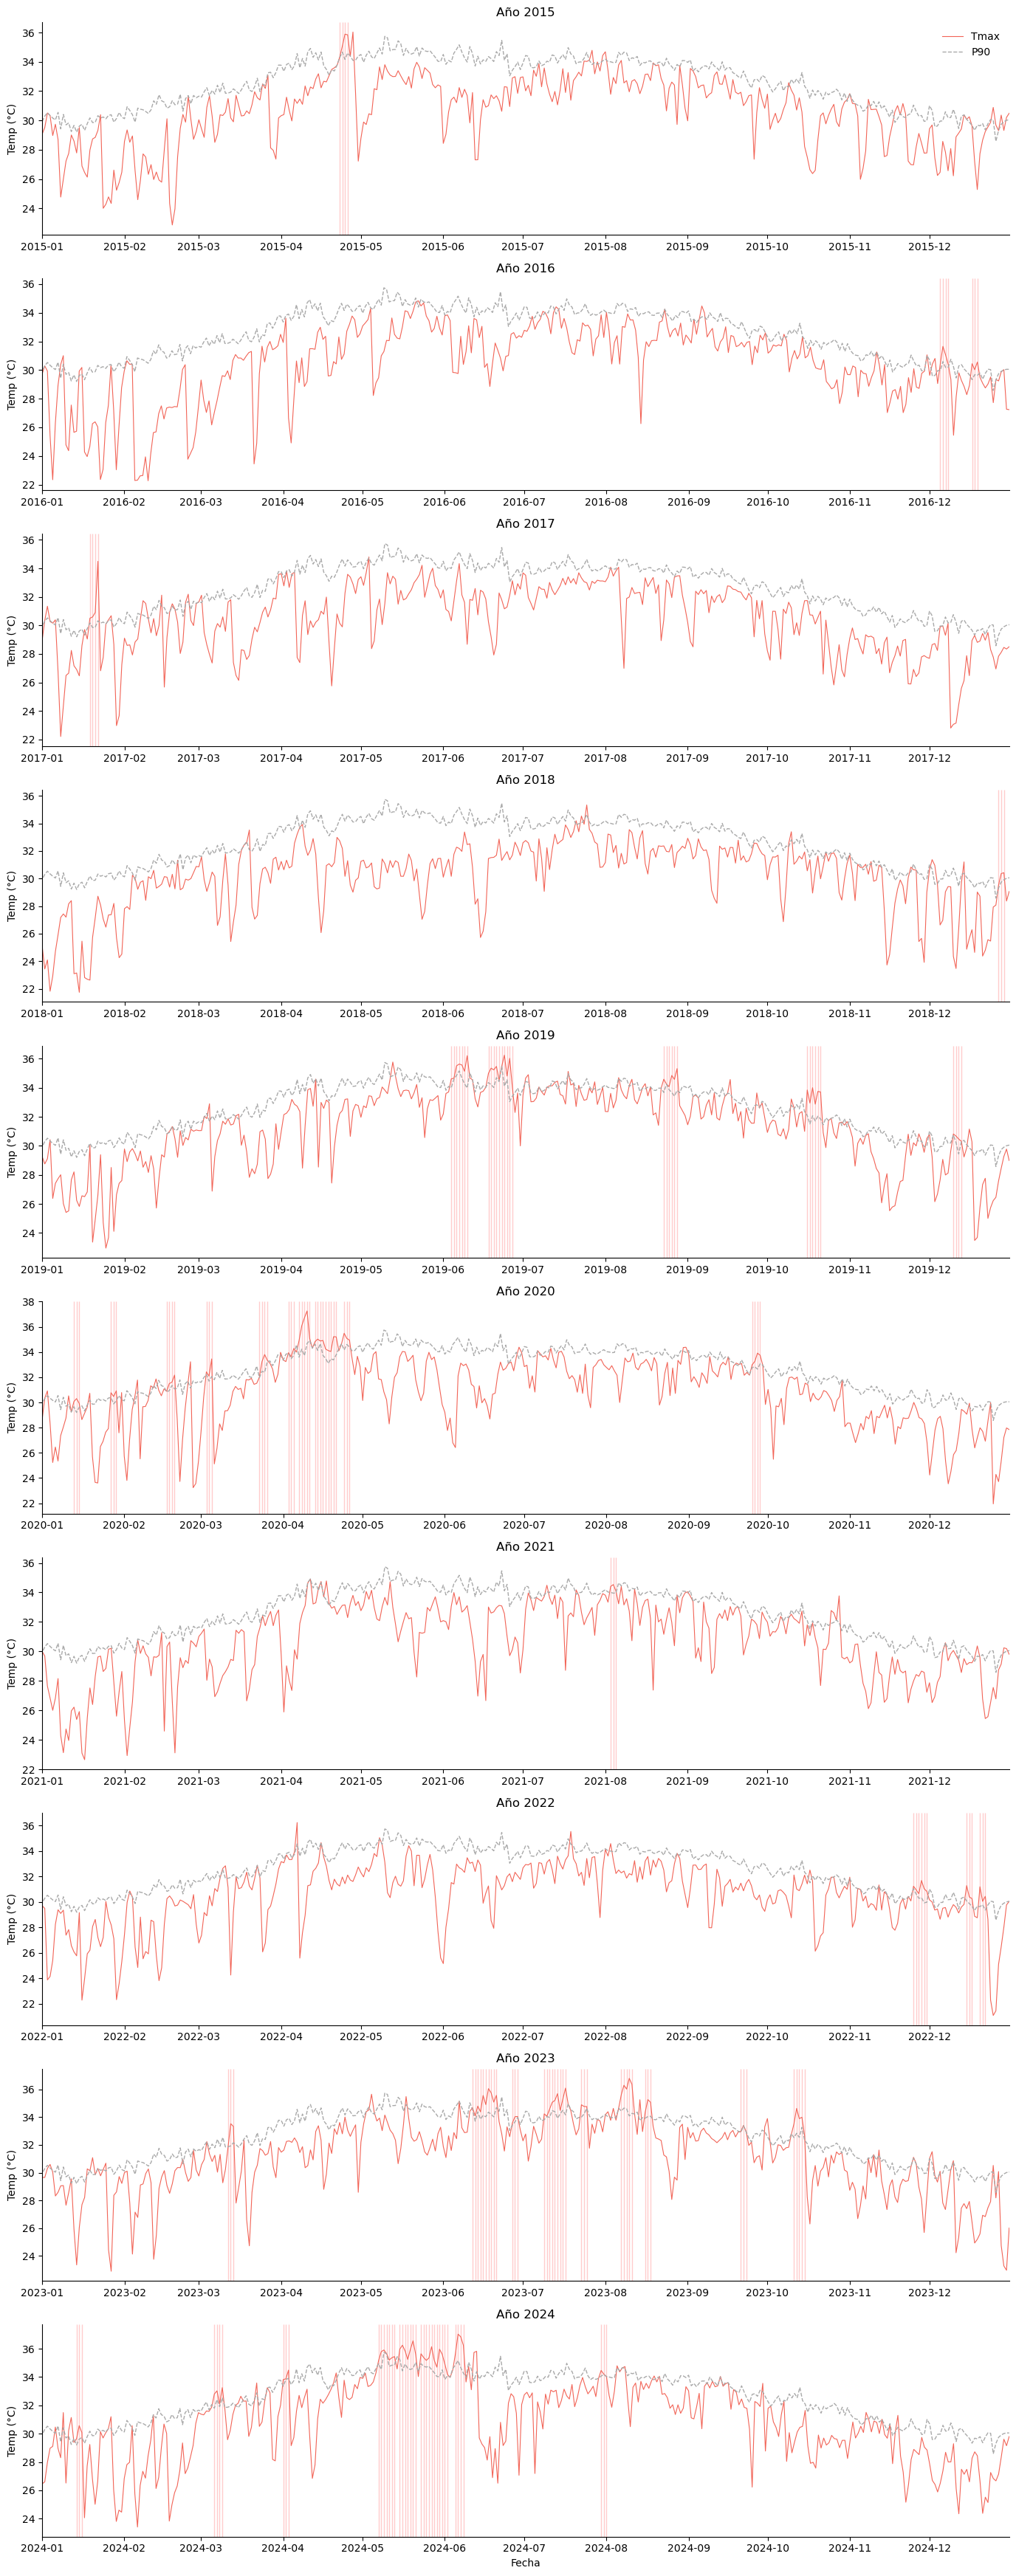

In [21]:
lat_point = 21.25
lon_point = -87.5

subset_ds = final_ds.sel(latitude=lat_point, longitude=lon_point, method="nearest")
subset_percentile = p_percentile.sel(latitude=lat_point, longitude=lon_point, method="nearest")

t_series_all = subset_ds["tmax2m"]
event_series_all = subset_ds["event_dummy"]

years = final_ds.year.values
n_years = len(years)

fig, axs = plt.subplots(n_years, 1, figsize=(14, 3.5 * n_years))

if n_years == 1:
    axs = [axs]

for i, year in enumerate(years):
    ax = axs[i]

    time_index = pd.to_datetime(subset_ds.sel(year=year)["valid_time"].values)
    t_series = t_series_all.sel(year=year).values
    event_series = event_series_all.sel(year=year).values

    doys = time_index.dayofyear
    doys = np.where(doys > 365, 365, doys)
    p90_series = [subset_percentile.sel(doy=day).item() for day in doys]

    ax.plot(time_index, t_series, color='#F26457', linewidth=0.8, label='Tmax')
    ax.plot(time_index, p90_series, color='darkgray', linestyle='--', linewidth=1.0, label='P90')
    ax.set_title(f"Año {year}")
    ax.set_ylabel("Temp (°C)")
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    for idx, is_event in enumerate(event_series):
        if is_event:
            ax.axvspan(time_index[idx], time_index[idx], alpha=0.2, color='red')

    start_date = pd.Timestamp(f"{year}-01-01")
    end_date = pd.Timestamp(f"{year}-12-31")
    ax.set_xlim([start_date, end_date])


axs[-1].set_xlabel("Fecha")
axs[0].legend(loc='upper right', frameon=False)

plt.tight_layout()
plt.show()
